### Imporing Dataset and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import altair as alt
alt.data_transformers.disable_max_rows()
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

class DataFrame(pd.DataFrame):
    def __init__(self, data=None, index=None, columns=None, dtype=None, copy=False):
        super().__init__(data=data, index=index, columns=columns, dtype=dtype, copy=copy)   
    def query(self, query):
        return DataFrame(super().query(query))     
    def visualize(self, filter_query=None):
        def numeric_distribution_chart(base, column_name):
            chart = base.encode(
                alt.X(column_name, bin=alt.Bin(maxbins=30), title="range: " + str(round(self[column_name].min(),2)) + " - " + str(round(self[column_name].max(),2))),
                alt.Y('count()', title=""),
            ).properties(
                width=128,
                height=128,
                title=column_name + " (numeric)"
            )
            return chart
        def categorical_distribution_chart(base, column_name):
            chart = base.transform_aggregate(
                count='count()',
                groupby=[column_name],
            ).transform_window(
                rank='rank()',
                sort=[alt.SortField('count', order='descending')]
            ).transform_filter(
                alt.datum.rank <= 12
            ).encode(
                x=alt.X('count:Q', title= str(len(self[column_name].unique())) + " categories"),
                y=alt.Y(column_name, sort='-x', title=""),
                color=alt.Color(column_name, legend=None),
            ).properties(
                width=128,
                height=128,
                title=column_name + " (categories)"
            )
            return chart
        
        processed_data_frame = self
        if filter_query is not None:
            processed_data_frame = self.query(filter_query)
        base = alt.Chart(processed_data_frame).mark_bar()
        charts = []
        
        type_of_columns = self.dtypes
        for column in processed_data_frame.columns:
            if type_of_columns[column] == "object":
                chart = categorical_distribution_chart(base, column)
            elif type_of_columns[column] == "int64" or type_of_columns[column] == "float64":
                chart = numeric_distribution_chart(base, column)
            else:
                continue
                
            charts.append(chart)
            
        charts = alt.hconcat(*charts)
        return charts
    def generate(self, config):
        def generate_by_z_value(config, n):
            mu = config["mu"]
            z_value = config["z_value"]
            value_at_z = config["value_at_z"]
            sigma = (value_at_z - mu) / z_value
            random_values = np.random.normal(mu, sigma, n)
            return random_values
        def generate_by_observations(config, n):
            if not isinstance(config["observations"], list):
                raise ValueError("observations must be a list")
            mu = np.mean(config["observations"])
            sigma = np.std(config["observations"])
            random_values = np.random.normal(mu, sigma, n)
            return random_values
        def generate_by_mu_std_dev(config, n):
            mu = config["mu"]
            std_dev = config["std_dev"]
            random_values = np.random.normal(mu, std_dev, n)
            return random_values
        
        generated_data = {}
        
        type_of_columns = self.dtypes
        for column in config:
            if column == "#":
                continue
            if type_of_columns[column] == "object":
                generated_data[column] = [config[column]] * config["#"]
            else:
                if not isinstance(config[column], int) and not isinstance(config[column], float):
                    if "z_value" in config[column] and "value_at_z" in config[column] and "mu" in config[column]:
                        random_values = generate_by_z_value(config[column], config["#"])
                    elif "observations" in config[column]:
                        random_values = generate_by_observations(config[column], config["#"])
                    elif "std_dev" in config[column] and "mu" in config[column]:
                        random_values = generate_by_mu_std_dev(config[column], config["#"])
                    else:
                        raise ValueError("Invalid configuration for column " + column)
                else:
                    random_values = [config[column]] * config["#"]
                    
                generated_data[column] = random_values
        return pd.DataFrame(generated_data)

In [2]:
milk = pd.read_csv('./milknew.csv')

In [3]:
DataFrame(milk).visualize()

alt.HConcatChart(...)

In [4]:
milk.head(5)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [5]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


### Data Preprocessing

#### Prepare the training data and testing data

In [11]:
train, test = train_test_split(milk, test_size=0.2, random_state=122)

x_train = train.drop(columns=['Grade'], axis=1)
y_train = train['Grade']

x_test = test.drop(columns=['Grade'], axis=1)
y_test = test['Grade']

#### Scale the feature matrix for training data and testing data

In [12]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(x_train)

Xtest_scaled = scaler.transform(x_test)

In [16]:
lr = LogisticRegression(random_state=122, max_iter=1000)

param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain_scaled, y_train)

best_score = grid_search.best_score_
print('Best accuracy score:', best_score)

best_params = grid_search.best_params_
print('Best Hyperparameters:', best_params)

best_model = grid_search.best_estimator_

Best accuracy score: 0.8559624086320919
Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}


In [17]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(Xtest_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8537735849056604


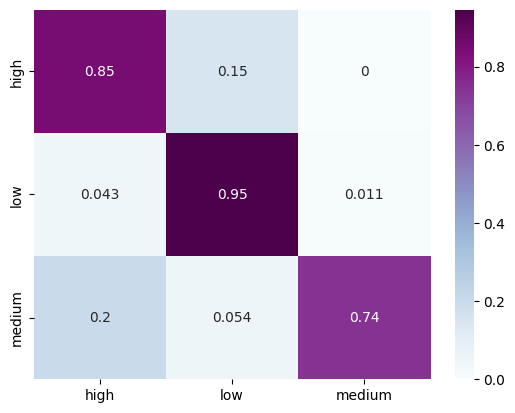

In [21]:
ws07000

In [23]:
report = classification_report(y_test, y_pred, target_names=grade)
print(report)

              precision    recall  f1-score   support

        high       0.67      0.85      0.75        46
         low       0.89      0.95      0.92        92
      medium       0.98      0.74      0.85        74

    accuracy                           0.85       212
   macro avg       0.85      0.85      0.84       212
weighted avg       0.87      0.85      0.86       212

